In [108]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Task 0
Data extraction: get the data from 3 tables & combine it into single `.csv` file.
After that read this file using pandas to create Dataframe.
So it will be all joined data in 1 dataframe. Quick check - should be 74818 rows in it.

In [135]:
conn = sqlite3.connect("../db.sqlite3")

product_data = pd.read_sql("SELECT * FROM restaurant_product", conn).set_index("id")
order_detail_data = pd.read_sql("SELECT * FROM restaurant_orderitem", conn).set_index("id")
order_data = pd.read_sql("SELECT * FROM restaurant_order", conn).set_index("id")
data = pd.merge(order_detail_data, product_data, left_on = "product_id", right_index=True, how = "inner").drop("product_id", axis=1)
data = pd.merge(data, order_data, left_on = "order_id", right_index=True, how = "inner").drop("order_id", axis=1)
data["datetime"] = pd.to_datetime(data["datetime"])
data

,quantity,price,name,datetime
id,,,,
1,2,0.80,Plain Papadum,2019-08-03 20:25:00
2,1,12.95,King Prawn Balti,2019-08-03 20:25:00
3,1,2.95,Garlic Naan,2019-08-03 20:25:00
4,1,3.95,Mushroom Rice,2019-08-03 20:25:00
5,1,8.95,Paneer Tikka Masala,2019-08-03 20:25:00
...,...,...,...,...
73771,2,12.95,Bengal Fish Biryani,2018-09-19 13:20:00
73774,2,12.95,Bengal Fish Biryani,2018-09-16 22:18:00
73796,1,12.95,Bengal Fish Biryani,2018-09-02 21:03:00


# Task 1
Get Top 10 most popular products in restaurant sold by Quantity.
Count how many times each product was sold and create a pie chart with percentage of popularity (by quantity) for top 10 of them.

Example:

![pie chart](../demo/pie.png)

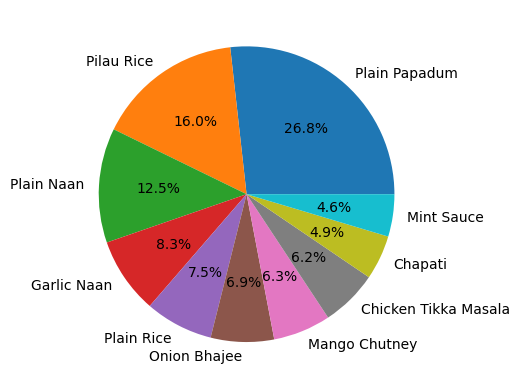

In [136]:
top_quantity = data.groupby("name")["quantity"].sum().sort_values(ascending=False).head(10)
labels = top_quantity.index
plt.pie(top_quantity, labels=labels, autopct='%1.1f%%')

plt.show()

# Task 2
Calculate `Item Price` (Product Price * Quantity) for each Order Item in dataframe.
And Make the same Top 10 pie chart, but this time by `Item Price`. So this chart should describe not the most popular products by quantity, but which products (top 10) make the most money for restaurant. It should be also with percentage.

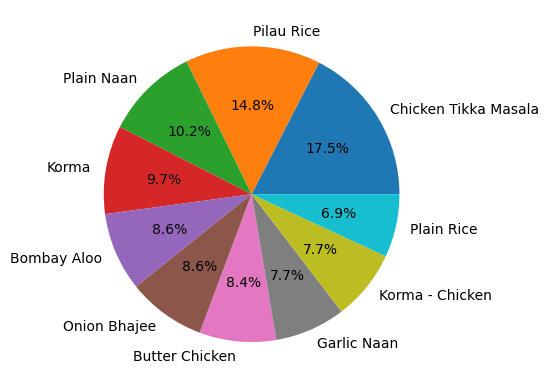

In [137]:
data["Item Price"] = data["price"] * data["quantity"]

top_profit = data.groupby("name")["Item Price"].sum().sort_values(ascending=False).head(10)
labels = top_profit.index
plt.pie(top_profit, labels=labels, autopct='%1.1f%%')

plt.show()

# Task 3
Calculate `Order Hour` based on `Order Datetime`, which will tell about the specific our the order was created (from 0 to 23). Using `Order Hour` create a bar chart, which will tell the total restaurant income based on the hour order was created. So on x-axis - it will be values from 0 to 23 (hours), on y-axis - it will be the total sum of order prices, which were sold on that hour.

Example:

![bar chart](../demo/bar.png)

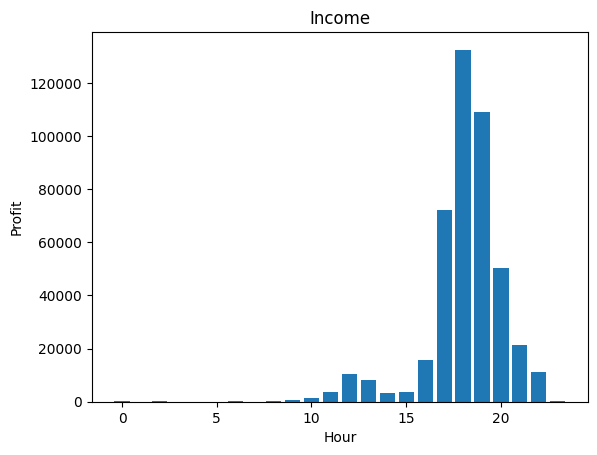

In [149]:
data["hour"] = data["datetime"].dt.hour
hours_profit = data.groupby("hour")["Item Price"].sum()
hours = hours_profit.index

plt.bar(hours, hours_profit)

plt.xlabel("Hour")
plt.ylabel("Profit")
plt.title("Income")
plt.show()

# Task 4
Make similar bar chart, but right now with `Order Day Of The Week` (from Monday to Sunday), and also analyze total restaurant income by each day of the week.

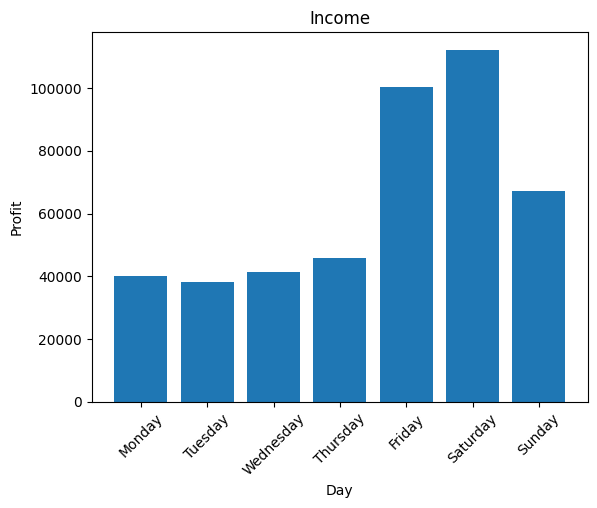

In [155]:
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

data["day"] = data["datetime"].dt.day_name()
data["day"] = pd.Categorical(data["day"], categories=day_order, ordered=True)
day_of_week_profit = data.groupby("day")["Item Price"].sum()
days = day_of_week_profit.index

plt.bar(days, day_of_week_profit)

plt.xlabel("Day")
plt.ylabel("Profit")
plt.title("Income")
plt.xticks(rotation=45)
plt.show()